In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# --------------------
# Config
# --------------------
DATA_PATH = "../DATA/Combined_UVA_Tuition_Cleaned.csv"   # adjust path if needed
OUT_DIR = "../OUTPUT/04_holt_linear_trend/"
COL_YEAR = "Year_Start"
COL_GAP  = "Tuition_Gap"

TEST_YEARS = 10           # last 10 years as test set
FORECAST_END_YEAR = 2030  # inclusive end year

os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
# --------------------
# Load & prep
# --------------------
df = pd.read_csv(DATA_PATH)

needed = [COL_YEAR, COL_GAP]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors="coerce").astype("Int64")
df[COL_GAP]  = pd.to_numeric(df[COL_GAP], errors="coerce")
df = df.dropna(subset=[COL_YEAR, COL_GAP]).sort_values(COL_YEAR).reset_index(drop=True)


In [4]:
# --------------------
# Chronological split
# --------------------
split_idx = max(0, len(df) - TEST_YEARS)
train = df.iloc[:split_idx].copy()
test  = df.iloc[split_idx:].copy()

years_train = train[COL_YEAR].to_numpy()
years_test  = test[COL_YEAR].to_numpy()

y_train = train[COL_GAP].to_numpy(dtype=float)
y_test  = test[COL_GAP].to_numpy(dtype=float)

print(f"Train: {years_train[0]}–{years_train[-1]}  |  Test: {years_test[0]}–{years_test[-1]}")


Train: 1970–2013  |  Test: 2014–2023


In [5]:
# --------------------
# Metrics
# --------------------
def mape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = np.where(y_true == 0, 1e-9, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def r2(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot) if ss_tot != 0 else np.nan


In [6]:
# --------------------
# Fit Holt on train & evaluate on test
# --------------------
holt = ExponentialSmoothing(
    y_train, trend="add", seasonal=None, initialization_method="estimated"
).fit()

y_pred_test = holt.forecast(len(y_test))
holt_mape = mape(y_test, y_pred_test)
holt_r2   = r2(y_test, y_pred_test)

last_n = min(5, len(y_test))
if last_n > 0:
    dir_true = np.sign(np.diff(y_test[-(last_n+1):]))
    dir_pred = np.sign(np.diff(y_pred_test[-(last_n+1):]))
    holt_dir = float((dir_true == dir_pred).mean())
else:
    holt_dir = np.nan

print(f"Holt → Test R²={holt_r2:.3f}, MAPE={holt_mape:.2f}%, Direction(last5)={holt_dir:.2f}")

# Save test predictions
pd.DataFrame({
    "year": years_test,
    "gap_actual": y_test,
    "gap_pred_holt": y_pred_test
}).to_csv(f"{OUT_DIR}/holt_test_predictions.csv", index=False)


Holt → Test R²=0.124, MAPE=7.10%, Direction(last5)=1.00


In [7]:
# --------------------
# Refit on full series & forecast to 2030
# --------------------
y_full   = df[COL_GAP].to_numpy(dtype=float)
years    = df[COL_YEAR].to_numpy()
last_year = int(years[-1])

extra_steps = int(FORECAST_END_YEAR - last_year)
if extra_steps > 0:
    holt_full = ExponentialSmoothing(
        y_full, trend="add", seasonal=None, initialization_method="estimated"
    ).fit()
    future_forecast = holt_full.forecast(extra_steps)
    future_years = np.arange(last_year + 1, FORECAST_END_YEAR + 1)
    pd.DataFrame({"year": future_years, "gap_forecast_holt": future_forecast}).to_csv(
        f"{OUT_DIR}/holt_future_forecast_2030.csv", index=False
    )
else:
    future_years = np.array([])
    future_forecast = np.array([])

In [8]:
# --------------------
# Save metrics
# --------------------
pd.DataFrame([{
    "test_R2": holt_r2,
    "test_MAPE": holt_mape,
    "directional_accuracy_last5": holt_dir
}]).to_csv(f"{OUT_DIR}/holt_metrics.csv", index=False)

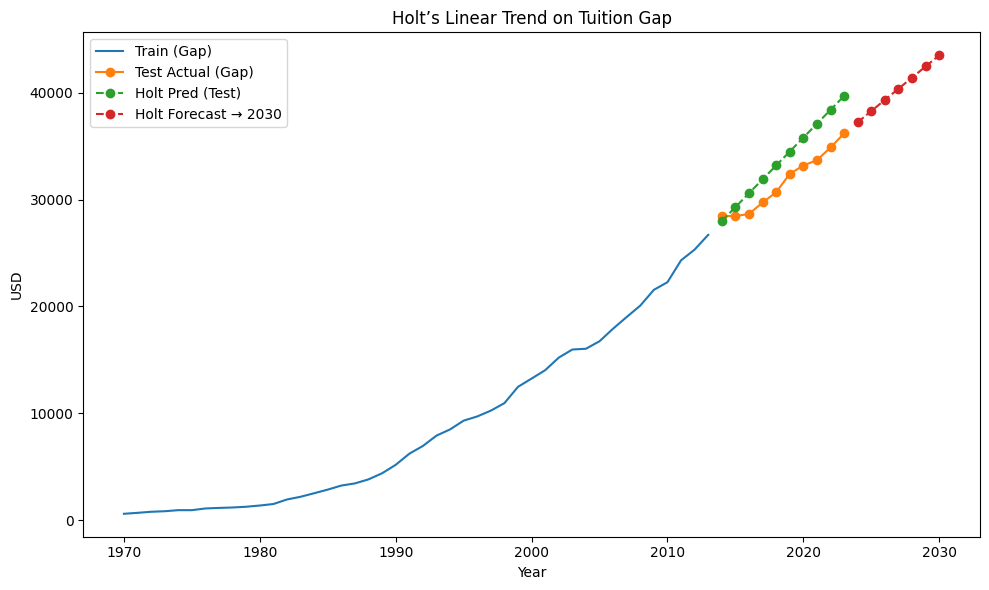

Saved: ../OUTPUT/04_holt_linear_trend//holt_test_predictions.csv, ../OUTPUT/04_holt_linear_trend//holt_future_forecast_2030.csv ../OUTPUT/04_holt_linear_trend//holt_metrics.csv, ../OUTPUT/04_holt_linear_trend//holt_gap_forecast.png


In [9]:
# --------------------
# Plot & save
# --------------------
plt.figure(figsize=(10,6))
plt.plot(years_train, y_train, label="Train (Gap)")
plt.plot(years_test, y_test, marker="o", label="Test Actual (Gap)")
plt.plot(years_test, y_pred_test, marker="o", linestyle="--", label="Holt Pred (Test)")

if future_years.size > 0:
    plt.plot(future_years, future_forecast, marker="o", linestyle="--", label="Holt Forecast → 2030")

plt.title("Holt’s Linear Trend on Tuition Gap")
plt.xlabel("Year")
plt.ylabel("USD")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/holt_gap_forecast.png", dpi=200)
plt.show()

print("Saved:",
      f"{OUT_DIR}/holt_test_predictions.csv,",
      f"{OUT_DIR}/holt_future_forecast_2030.csv" if extra_steps > 0 else "(no future file)",
      f"{OUT_DIR}/holt_metrics.csv,",
      f"{OUT_DIR}/holt_gap_forecast.png")